In [1]:
from sklearn.metrics import mean_squared_error
from fbprophet.plot import plot_plotly
import matplotlib.pyplot as plt
from fbprophet import Prophet
import plotly.offline as py
import pandas as pd
import numpy as np
%matplotlib inline
import glob

In [2]:
directory = 'data/*.csv' 
files = glob.glob(directory)[0]

In [3]:
df = pd.read_csv(files, index_col=['Month'], parse_dates=['Month'], dayfirst=True)
df = df.reset_index(drop=False)
df.columns = ['ds', 'y']

In [4]:
df.head()

ds       y
0 1985-01-01  227.86
1 1985-02-01  198.24
2 1985-03-01  194.97
3 1985-04-01  184.88
4 1985-05-01  196.79

In [5]:
df.tail()

ds       y
137 1996-06-01  268.79
138 1996-07-01  288.94
139 1996-08-01  290.16
140 1996-09-01  250.69
141 1996-10-01  240.80

Обучим с помощью `Prophet` базовую модель на наших данных.

In [6]:
model = Prophet(weekly_seasonality=False, daily_seasonality=False)
model.fit(df)

Построим прогноз на 3 года

In [7]:
future = model.make_future_dataframe(periods=36, freq='MS')

In [8]:
future.head()

ds
0 1985-01-01
1 1985-02-01
2 1985-03-01
3 1985-04-01
4 1985-05-01

In [9]:
future.tail()

ds
173 1999-06-01
174 1999-07-01
175 1999-08-01
176 1999-09-01
177 1999-10-01

Аппроксимацию модели и прогноз получим спомощью функции `predict`

In [10]:
forecast = model.predict(future)

In [11]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)

ds        yhat  yhat_lower  yhat_upper
166 1998-11-01  252.257381  244.441197  260.238781
167 1998-12-01  274.260698  266.822224  281.535125
168 1999-01-01  282.645554  275.226303  290.470394
169 1999-02-01  256.385908  248.909190  264.073617
170 1999-03-01  260.069476  252.526129  267.727970
171 1999-04-01  245.217700  237.333721  253.047777
172 1999-05-01  261.141839  253.650390  269.054855
173 1999-06-01  281.371736  272.612711  289.360871
174 1999-07-01  305.937593  297.508207  314.407921
175 1999-08-01  305.671478  297.240233  314.154289
176 1999-09-01  269.131575  260.371925  277.446961
177 1999-10-01  259.920236  251.610247  268.321462

Получим график и отобразим величину MSE на нём.

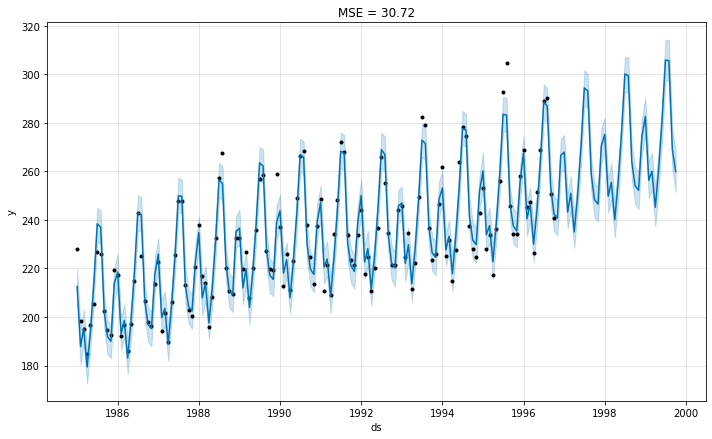

In [12]:
mse = mean_squared_error(forecast['yhat'][:df.shape[0]], df['y'])
model.plot(forecast)
plt.title("MSE = %.2f" % mse )
plt.show()

MSE = 30.72 - результат скорее хороший,но попытаемся его улучшить различными преобразованиями.
Для начала отобразим компоненты временного ряда с помощью функции `plot_components'.

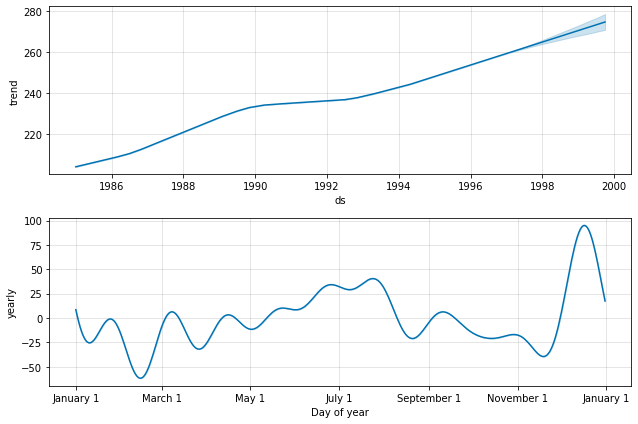

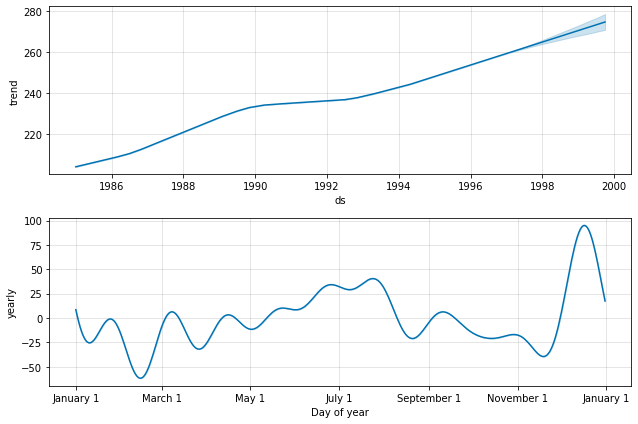

In [13]:
model.plot_components(forecast)

Воспользуемся интерактивной визуализации данных, чтобы потом можно было проанализировать наш ряд более подробно и добавить какие-то признаки или, например, праздники, которые учтет модель.

In [14]:
py.init_notebook_mode()
fig = plot_plotly(model, forecast)  # This returns a plotly Figure
py.iplot(fig)

Попробуем добавить в модель годовую сезонность с N = fourier_order = 11 (не будем пробовать 10, так как Prophet изначально использует данное количество).

In [15]:
model = Prophet(weekly_seasonality=False, daily_seasonality=False, growth = 'linear',yearly_seasonality=False)
model.add_seasonality(name='yearly', period=365.25, fourier_order=11)
model.fit(df)
future = model.make_future_dataframe(periods=36, freq='MS')
forecast = model.predict(future)
mse = mean_squared_error(forecast['yhat'][:df.shape[0]], df['y'])
model.plot(forecast)
plt.title("MSE = %.2f" % mse )
plt.show()

Мы улучшили MSE на два! Это здорово!
Посмотре детально на график я обнаружил скачки на летних каникулах, поэтому добавим в качестве праздников весь летний период с шириной размаха 60 от середины июля, а также обнаружил, что зимой, в новогодние праздники тоже появляется упадок пользования электроэнергии.

In [16]:
summer = pd.DataFrame({'holiday': 'summer_hoildays', 
                         'ds': pd.to_datetime([str(x)+'-07-15' for x in range(1985, 1996)]),
                         'lower_window': -30, 
                         'upper_window': 30
                        })

In [17]:
newyear = pd.DataFrame({'holiday': 'NewYear', 
                         'ds': pd.to_datetime([str(x)+'-01-01' for x in range(1985, 1996)]),
                         'lower_window': -7, 
                         'upper_window': 7
                        })

In [18]:
holidays_full = pd.concat((summer, newyear))

Сначала добавим в модель праздники, которая Prophet будет учитывать для такой страны, как US, потому что мой ряд является временным рядом по пользованию электроэнергии в U.S.

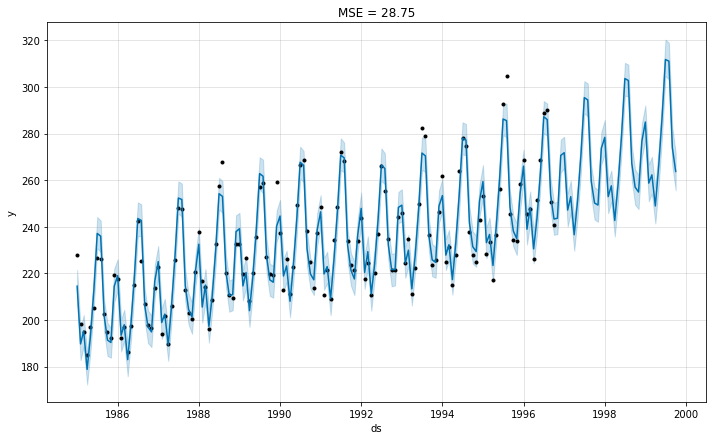

In [19]:
model = Prophet(weekly_seasonality=False, daily_seasonality=False, growth = 'linear',yearly_seasonality=False)
model.add_seasonality(name='yearly', period=365.25, fourier_order=11)
model.add_country_holidays(country_name='US')
model.fit(df)
future = model.make_future_dataframe(periods=36, freq='MS')
forecast = model.predict(future)
mse = mean_squared_error(forecast['yhat'][:df.shape[0]], df['y'])
model.plot(forecast)
plt.title("MSE = %.2f" % mse )
plt.show()

По MSE модель лучше предыдщей. Уберем теперь праздники U.S, добавив только учет летней передышки.

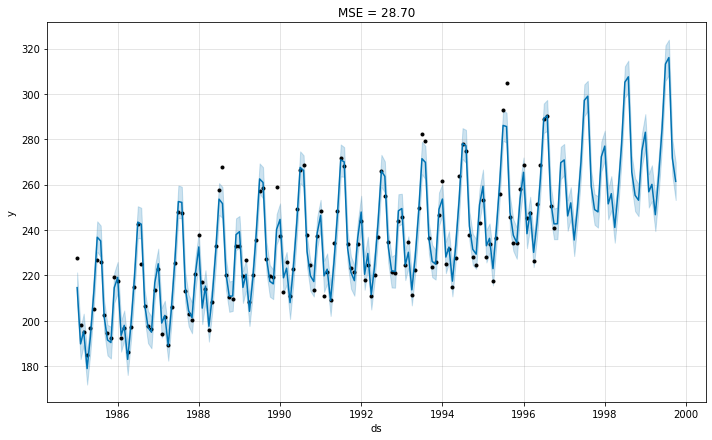

In [20]:
model = Prophet(weekly_seasonality=False, daily_seasonality=False, growth = 'linear',yearly_seasonality=False,holidays=summer)
model.add_seasonality(name='yearly', period=365.25, fourier_order=11)
model.fit(df)
future = model.make_future_dataframe(periods=36, freq='MS')
forecast = model.predict(future)
mse = mean_squared_error(forecast['yhat'][:df.shape[0]], df['y'])
model.plot(forecast)
plt.title("MSE = %.2f" % mse )
plt.show()

Модель улучшилась, ненамного, но все же. Добавим теперь полный набор праздников.

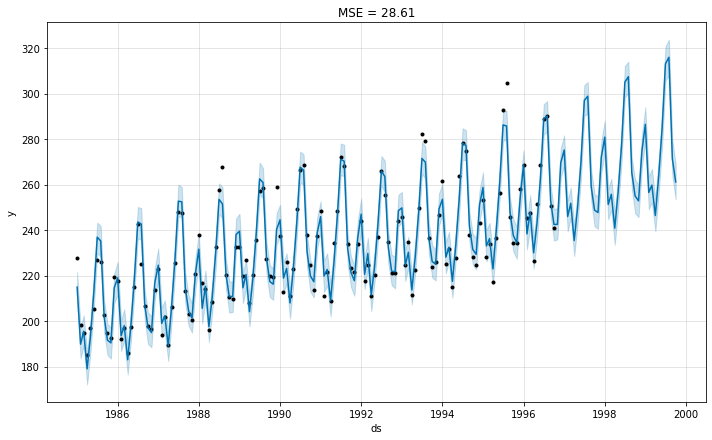

In [21]:
model = Prophet(weekly_seasonality=False, daily_seasonality=False, growth = 'linear',yearly_seasonality=False,holidays=holidays_full)
model.add_seasonality(name='yearly', period=365.25, fourier_order=11)
model.fit(df)
future = model.make_future_dataframe(periods=36, freq='MS')
forecast = model.predict(future)
mse = mean_squared_error(forecast['yhat'][:df.shape[0]], df['y'])
model.plot(forecast)
plt.title("MSE = %.2f" % mse )
plt.show()

Модель стала еще лучше! Теперь добавим экзогенный фактор, например, проанализировав временной ряд я заметил, что в ноябре тоже появляется снижение электропотребления. Поэтому, добавим `november` в качестве экзогенного фактора.

In [22]:
def november(ds):
    return 1 if ds.month == 11 else 0

In [23]:
df['november'] = df['ds'].apply(november)

Для построения прогноза добавим наш регрессор в прогнозную модель.

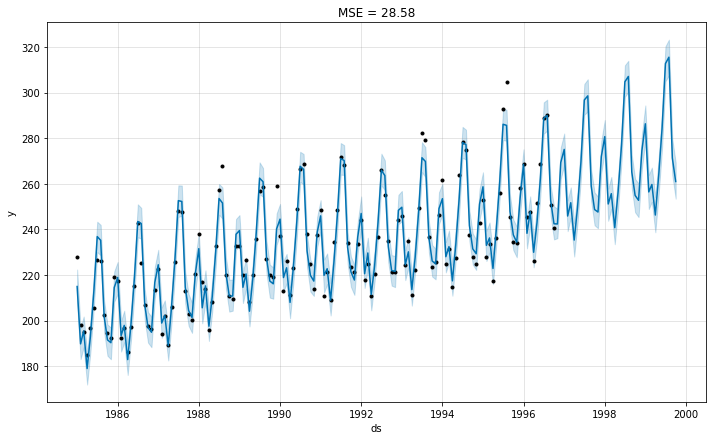

In [24]:
model = Prophet(weekly_seasonality=False, daily_seasonality=False, growth = 'linear',yearly_seasonality=False,holidays=holidays_full)
model.add_seasonality(name='yearly', period=365.25, fourier_order=11)
model.add_regressor('november')
model.fit(df)

future = model.make_future_dataframe(periods=36, freq='MS')
future['november'] = future['ds'].apply(november)
forecast = model.predict(future)
mse = mean_squared_error(forecast['yhat'][:df.shape[0]], df['y'])
model.plot(forecast)
plt.title("MSE = %.2f" % mse )
plt.show()

MSE уменьшилось! Это наилучшая модель, которую мне удалось получить путём анализа временного ряда и добавления в него различных факторов, влияющих на поведение.